In [1]:
# make sure to run this cell to import the external files we need for today
# and load in the appropriate packages

!git clone https://github.com/ccbskillssem/pythonbootcamp.git

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Cloning into 'pythonbootcamp'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 117 (delta 4), reused 13 (delta 3), pack-reused 98
Receiving objects: 100% (117/117), 81.24 MiB | 10.33 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Updating files: 100% (28/28), done.


# Introduction

Welcome to our final day of PyCamp! Today, you'll be embarking on your final mini-project, which will unify concepts and themes you've learned over the past several days.

## Single-cell in a nutshell

Recall the last biology class that you took: you probably learned at some point the **central dogma of molecular biology**, which is a fancy name for the principle that DNA gives rise to RNA, and RNA gives rise to protein.

Scientists are able to survey DNA, RNA, and proteins using various methods: **sequencing**, the process of recording the nucleic acid sequence of a DNA/RNA molecule, is quite popular due to its relative scalability and cost efficiency.
* DNA sequencing gives us information on the organism's **genome**, akin to the blueprint of its biology. (We will not be discussing this today, sorry!)
* **RNA sequencing** gives us insight into the creation of an organism's biology: what elements of the blueprint are being realized?

**Single-cell RNA sequencing** (scRNA-seq) is an increasingly popular method for capturing and assigning identity (gene origin) to RNA molecules circulating within a single cell. Briefly, tissue samples are dissociated into single cells, and each RNA molecule within a cell is labeled with a barcode of sorts that indicates its cellular origin. The number and identity of RNA molecules per cell is then determined computationally. This method yields high(er) resolution insights into tissue heterogeneity and temporal cellular processes, such as cell differentiation.

> *Note*: On Monday, we said that our goal isn't to teach you specific bioinformatic analyses, and that's still true. **Today's mini-project is not a full pipeline for analyzing single-cell data**: however, you will be much better equipped to learn how to do that once you're done with the mini-project. (Finish the whole mini-project and you'll realize how much is in your grasp right now!)



## What is a cell atlas?

 A **cell atlas** is an analyzed single-cell dataset comprising multiple cell types over some type of biological scale. Cell atlases grant insight into  cellular heterogeneity across anatomical and physiological scales, and they are especially useful for studying healthy development (ex. stem cell differentiation) and disease progression (ex. cancer).

 The [Tabula Muris Senis](https://www.nature.com/articles/s41586-020-2496-1) is a cell atlas of aging mouse tissues, comprised of samples from multiple healthy mouse specimens of varying ages. For our mini-project, we'll use a subset of the cell atlas data and attempt to replicate some of the findings from the linked paper.

## Overview

We want to work the Tabula Muris Senis data because it has both real biological meaning (spoiler alert: gene expression does change with aging!) *and* is natively represented in a tabular format, much like the arrays and DataFrames you've become accustomed to handling in the last couple of days.

We're going to examine the bladder dataset, as the authors found that bladder tissues change quite significantly with age.

> "*The bladder shows pronounced changes in cell-type composition with age: whereas the mesenchymal compartment of this tissue decreases by a factor of three over the lifetime of the mouse, the urothelial compartment increases by a similar amount...*"

This dataset contains two tables:

1. **A metadata table**: This will be a DataFrame that describes auxilary features about our data: for example, what was the age of each mouse? What tissue did our sample come from, and how many RNA molecules were captured in each sample? This information can be quite useful for guiding what we do with the data.
2. **A count matrix**: This will be a DataFrame that describes *gene expression* in each of our cells. This means that we'll have information on how many "instances" of a gene (read: RNA molecules) were found per cell. We should expect that some genes will be highly expressed (many RNA molecules) in some cells, but near absent in others.

Let's go ahead and get started!

## Downloading the data

The Tabula Muris Senis data is hosted on an external server: we can download a local copy of our desired data using a command line tool called `wget`. Although we don't have access to a terminal in the free version of Colab, we can still execute command line commands using **magic commands**.

1. **For a single line, use the `!` line magic command at the beginning of the line**: This tells the notebook that the following line should be run via the comand line.
2. **For multiple lines, use the `%%bash` magic command at the beginning of the cell.** This tells the notebook that all lines following `%%bash` need to be run via the command line.

These commands work in both Colab notebooks and Jupyter notebooks, and they're very convenient for documenting your full analysis workflow. You can read about other useful notebook magic commands [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html).

In [2]:
# run this cell to download: this should only take a few seconds
%%bash
wget https://cells.ucsc.edu/tabula-muris-senis/facs/bladder/exprMatrix.tsv.gz -O bladder-facs.tsv.gz --no-check-certificate --no-verbose
wget https://cells.ucsc.edu/tabula-muris-senis/facs/bladder/meta.tsv -O bladder-facs.meta.tsv --no-check-certificate --no-verbose

  Unable to locally verify the issuer's authority.
2024-01-04 22:07:06 URL:https://cells.ucsc.edu/tabula-muris-senis/facs/bladder/exprMatrix.tsv.gz [39360514/39360514] -> "bladder-facs.tsv.gz" [1]
  Unable to locally verify the issuer's authority.
2024-01-04 22:07:07 URL:https://cells.ucsc.edu/tabula-muris-senis/facs/bladder/meta.tsv [334389/334389] -> "bladder-facs.meta.tsv" [1]


# Review & warm-up

We'll begin with a series of review exercises that we'll do together. Afterwards, you'll have time to work on the mini-project.

## Examining the metadata
Yesterday, you learned how you can perform many familiar Excel-like functions using `pandas` DataFrame functions and methods. We'll have you briefly refresh these skills by examining our metadata.

Our metadata is stored in a simple `.tsv` file called `bladder-facs.meta.tsv`, which we'll load in below:

In [3]:
# try it out:
# use the appropriate pandas function to load in the metadata table and assign it to a variable called metadata_facs
# then use the .head() method to preview the first few rows of the table

metadata_facs = pd.read_table('bladder-facs.meta.tsv')
metadata_facs.head()

,index,FACS.selection,age,batch,cell,cell_ontology_class,cell_ontology_id,cellid,free_annotation,mouse.id,plate,sex,well,Expressed Genes,UMI Count,Louvain Cluster,leiden,cluster_names
0,E4_B000836_S40_L003.mus-0-0,Multiple,24m,0,NaN,bladder cell,CL:1001319,E4_B000836,bladder mesenchymal cell (Scara5+),24_60_M,B000836,male,E4,3588,5226.1284,1,1,1_bladder cell
1,G13_B000836_S97_L003.mus-0-0,Multiple,24m,0,NaN,bladder urothelial cell,CL:1001428,G13_B000836,luminal bladder epithelial cell (umbrella cell),24_60_M,B000836,male,G13,4249,5000.5464,0,2,0_bladder urothelial cell
2,H15_B000836_S123_L003.mus-0-0,Multiple,24m,0,NaN,bladder urothelial cell,CL:1001428,H15_B000836,basal bladder epithelial cell (Krt5+),24_60_M,B000836,male,H15,3347,5055.2600,0,0,0_bladder urothelial cell
3,N10_B000836_S262_L003.mus-0-0,Multiple,24m,0,NaN,bladder urothelial cell,CL:1001428,N10_B000836,luminal bladder epithelial cell (umbrella cell),24_60_M,B000836,male,N10,3314,5045.6357,0,2,0_bladder urothelial cell
4,O16_B000836_S292_L003.mus-0-0,Multiple,24m,0,NaN,bladder urothelial cell,CL:1001428,O16_B000836,basal bladder epithelial cell (Krt5+),24_60_M,B000836,male,O16,4168,5039.3790,0,0,0_bladder urothelial cell


In [4]:
# try it out:
# inspect the number of rows and columns in this table

metadata_facs.shape

(1740, 18)

Each row of `metadata_facs` contains the metadata of a single cell in the dataset. The `index` column contains a unique string "name" for each cell: let's use this as the actual row Index (column of row labels) for the DataFrame.

In [5]:
# try it out:
# use the appropriate method to set the index of metadata_facs to the index column
# then use .head() to check that it worked

metadata_facs.set_index('index', inplace = True)
metadata_facs.head()

,FACS.selection,age,batch,cell,cell_ontology_class,cell_ontology_id,cellid,free_annotation,mouse.id,plate,sex,well,Expressed Genes,UMI Count,Louvain Cluster,leiden,cluster_names
index,,,,,,,,,,,,,,,,,
E4_B000836_S40_L003.mus-0-0,Multiple,24m,0,NaN,bladder cell,CL:1001319,E4_B000836,bladder mesenchymal cell (Scara5+),24_60_M,B000836,male,E4,3588,5226.1284,1,1,1_bladder cell
G13_B000836_S97_L003.mus-0-0,Multiple,24m,0,NaN,bladder urothelial cell,CL:1001428,G13_B000836,luminal bladder epithelial cell (umbrella cell),24_60_M,B000836,male,G13,4249,5000.5464,0,2,0_bladder urothelial cell
H15_B000836_S123_L003.mus-0-0,Multiple,24m,0,NaN,bladder urothelial cell,CL:1001428,H15_B000836,basal bladder epithelial cell (Krt5+),24_60_M,B000836,male,H15,3347,5055.2600,0,0,0_bladder urothelial cell
N10_B000836_S262_L003.mus-0-0,Multiple,24m,0,NaN,bladder urothelial cell,CL:1001428,N10_B000836,luminal bladder epithelial cell (umbrella cell),24_60_M,B000836,male,N10,3314,5045.6357,0,2,0_bladder urothelial cell
O16_B000836_S292_L003.mus-0-0,Multiple,24m,0,NaN,bladder urothelial cell,CL:1001428,O16_B000836,basal bladder epithelial cell (Krt5+),24_60_M,B000836,male,O16,4168,5039.3790,0,0,0_bladder urothelial cell


Now, let's review a couple of very useful methods that you'll need for today's mini-project.

Although we know that each row represents one cell, we still don't know how many samples are represented in this dataset, nor do we know the identity and composition (cell number, cell type) of each sample.

`.unique()` and `.value_counts()` are powerful methods that summarize the unique values of a categorical column and the number of value counts associated with those unique values.

* `.unique()` is a method for **Series**: it does not require any input, and it returns an array of unique values contained in the Series. This method works well when you don't need counts, you only need values.
* `.value_counts()` is a method for **DataFrames**: it takes a variable name and returns a Series with aggregated value counts for each unique value. By default, the Series will be sorted in ascending order of counts.
  * **Note**: By default, this method excludes `NA` values from the values to be counted. You can include `NA` values using the `dropna = False` parameter.

In [6]:
# try it out:
# access the column names of metadata_facs

metadata_facs.columns

Index(['FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class',
       'cell_ontology_id', 'cellid', 'free_annotation', 'mouse.id', 'plate',
       'sex', 'well', 'Expressed Genes', 'UMI Count', 'Louvain Cluster',
       'leiden', 'cluster_names'],
      dtype='object')

In [7]:
# try it out:
# use .unique() to get unique values in mouse.id

metadata_facs['mouse.id'].unique()

array(['24_60_M', '24_58_M', '24_59_M', '24_61_M', '3_39_F', '3_8_M',
       '3_9_M', '3_10_M', '3_56_F', '3_38_F'], dtype=object)

In [8]:
# try it out:
# use .value_counts() to get the number of cells per mouse.id

metadata_facs.value_counts('mouse.id')

mouse.id
3_9_M      340
3_10_M     327
3_8_M      311
24_58_M    209
3_56_F     179
24_59_M    171
3_39_F      84
3_38_F      65
24_61_M     48
24_60_M      6
dtype: int64

`.value_counts()` is especially useful if you want to aggregate counts across multiple variables.

There are two columns in `metadata_facs` that will can tell us about cellular identity: `cell_ontology_class` and `free_annotation`. `cell_ontology_class` tells us about the anatomical placement of the cell, and `free_annotation` tells us about the specific cell type.

We'll revisit this later in the project, but for now, let's use this as an opportunity to test out `.value_counts()` for multiple variables.

In [9]:
# try it out:
# find the number of cells in each sample for each (anatomical) cell type

# bonus:
# this Series would be more readable if each sample's counts were shown ordered
# by mouse.id, rather than ordered by count values. how might you do this?

metadata_facs.value_counts(['mouse.id', 'cell_ontology_class'], sort = False)

mouse.id  cell_ontology_class    
24_58_M   bladder cell                30
          bladder urothelial cell    179
24_59_M   bladder cell                36
          bladder urothelial cell    135
24_60_M   bladder cell                 1
          bladder urothelial cell      5
24_61_M   bladder cell                18
          bladder urothelial cell     30
3_10_M    bladder cell               106
          bladder urothelial cell    221
3_38_F    bladder cell                16
          bladder urothelial cell     49
3_39_F    bladder cell                28
          bladder urothelial cell     56
3_56_F    bladder cell                85
          bladder urothelial cell     94
3_8_M     bladder cell               199
          bladder urothelial cell    112
3_9_M     bladder cell               217
          bladder urothelial cell    123
dtype: int64

## Plotting the metadata

For the past couple of days, you've been using `pyplot` to create simple plots from arrays and DataFrame columns.

Let's start off with a quick review: let's say that we want to create a bar plot with the `sex` categorical on the x axis and cell counts for each value of `sex` on the y axis.

We can use a function called `plt.bar()` to create a simple bar plot. `plt.bar()` requires two inputs:
1. `x`: A list, array, or Series with categories to be plotted on the x axis. These will be the labels for each bar.
2. `height`: A list, array, or Series with numerical values to be plotted on the y axis.

Different plotting functions will require different inputs, depending on the type of plot: for example, `plt.scatter()` wouldn't take `height` as an input, it would require `y` as an input.
> It's almost essential to keep the documentation for your plotting package open in a separate tab. Remember, *don't memorize*, just know where to look for answers.

<BarContainer object of 2 artists>

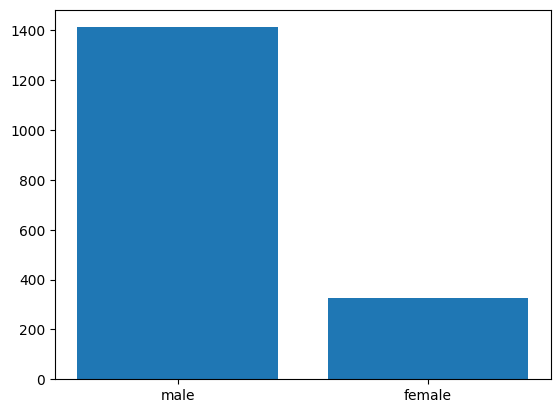

In [10]:
# try it out:
# use plt.bar() to create the aforementioned plot
# check the y height of each bar against the categorical counts in the previous cell

plt.bar(x = metadata_facs['sex'].unique(), height = metadata_facs['sex'].value_counts())

We can adjust the size of our plots using `plt.figure()` with the `figsize` parameter. `figsize` accepts a tuple of integers in the format of `(width, height)`.

<BarContainer object of 2 artists>

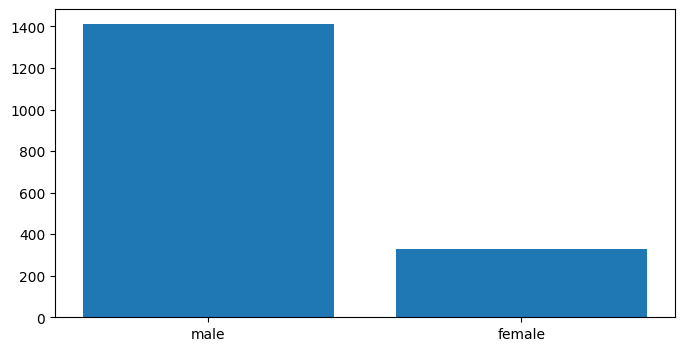

In [11]:
# try it out:
# copy your plt.bar() command from the previous cell
# set plt.figure() with a figsize tuple of your choice

plt.figure(figsize = (8, 4))
plt.bar(x = metadata_facs['sex'].unique(), height = metadata_facs['sex'].value_counts())

So far, we've only made plots to help us inspect our data. If we want to make presentation-worthy plots, we need to add labels.

* `plt.title()`: Takes a string as input and labels the top of the plot with the string. Takes an optional `size` parameter (ex. `size = 16`) to adjust the title size.
* `plt.xlabel()` and `plt.ylabel()`: Same as above, but labels the x and y axes respectively.

Text(0, 0.5, 'Total cells in dataset')

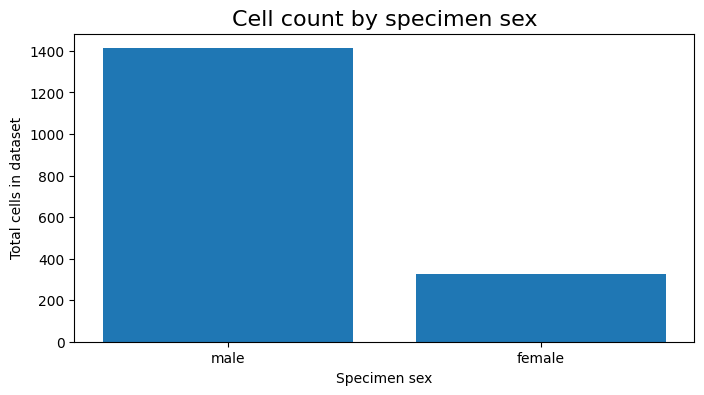

In [12]:
# try it out:
# copy your code from the previous cell
# use the plt functions shown above to add plot labels

plt.figure(figsize = (8, 4))
plt.bar(x = metadata_facs['sex'].unique(), height = metadata_facs['sex'].value_counts())

plt.title("Cell count by specimen sex", size = 16)
plt.xlabel("Specimen sex")
plt.ylabel("Total cells in dataset")

It's fairly rare that we only want to plot the counts of one categorical. For example, what if we wanted to create a grouped bar chart showing cell counts split by sample sex and age?

It's time for us to introduce `seaborn`, a package that extends the plotting functionalities of `pyplot`.

In [13]:
# make sure to run this cell!
import seaborn as sns

`seaborn` provides useful functions that can simultaneously aggregate and plot data directly from DataFrames. It's exceptionally powerful for visualizing mixed categorical and numerical data, which is what we want to do today.
<br><br>

<img src = 'https://seaborn.pydata.org/_images/function_overview_8_0.png' align = 'center'>
<br><br>

`seaborn` functions are built with DataFrames in mind. Most functions tend to take similar key inputs:
* `data`: The DataFrame containing your data of interest. **This is always the first input to a `seaborn` function.**
* `x`: A variable to be plotted on the x-axis.
* `y`: A variable to be plotted on the y-axis.
* `hue`: A variable for coloring groups in the plot.

Let's return to our earlier prompt: we want to create a grouped bar chart showing cell counts split by sample sex and age. Let's start by calculating the counts we expect:

In [14]:
# try it out:
# use the same .value_counts() method to get cell counts for each combination of sex and age

metadata_facs.value_counts(['sex', 'age'])

sex     age
male    3m     978
        24m    434
female  3m     328
dtype: int64


`sns.countplot()` takes a column of values and calculates counts, plotting them as bars. It uses the `hue` parameter to subdivide bars, and we can use it to create our desired subdivided bar chart.

Text(0, 0.5, 'Total cells in dataset')

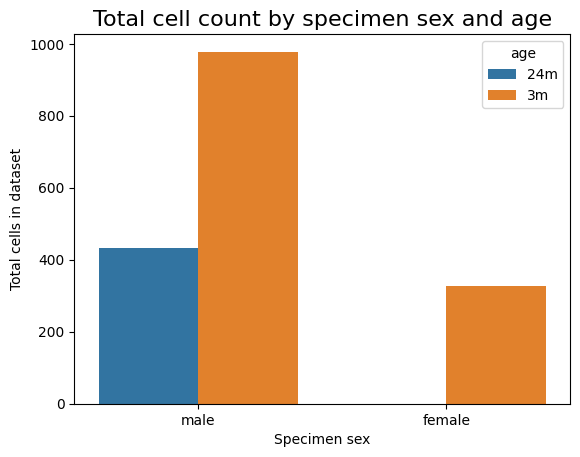

In [15]:
# try it out:
# use sns.countplot() with two categorical variables: sex and age
# we want to plot sex on the x axis and subdivide bars by age
# make sure to add labels and a title

sns.countplot(data = metadata_facs, x = 'sex', hue = 'age')

plt.title("Total cell count by specimen sex and age", size = 16)
plt.xlabel("Specimen sex")
plt.ylabel("Total cells in dataset")

It seems like cells from 3 month old male samples are overrepresented in this dataset. One reason might be that some samples yielded more cells than others.

Using `sns.countplot()`, create a plot that:
- Shows total cell count per `mouse.id`.
- Uses the optional `palette` parameter with a palette of your choosing: you can view different options [here](https://www.practicalpythonfordatascience.com/ap_seaborn_palette). (We recommend the classic `viridis` or Berkeley blue-and-gold `cividis`!)

> *Bonus*: Use the optional `order` parameter to specify the order of `mouse.id` values: the specimen with the greatest number of total cells should be first, and the rest of the specimens should follow in descending order.

<Axes: xlabel='count', ylabel='mouse.id'>

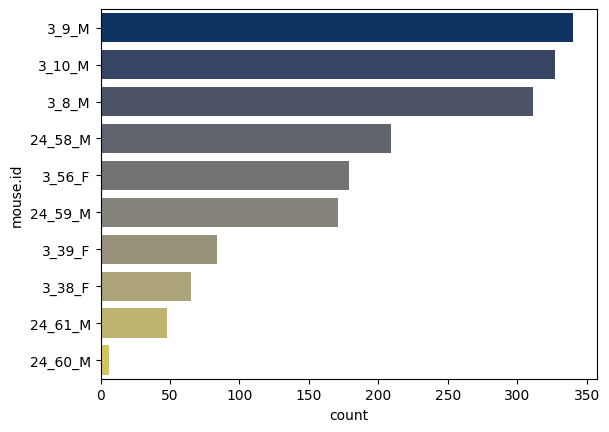

In [16]:
# try it out:
# create the plot described above
# note: sns.countplot() takes either x or y as input
# x creates a horizontal plot, y creates a vertical plot

sns.countplot(metadata_facs, y = 'mouse.id',
              order = metadata_facs.value_counts('mouse.id').index,
              palette = 'cividis')

# Mini-project: Tabula Muris Senis bladder data

It's time to start on the mini-project!

This project will require you to revisit topics you've learned in the past few days, emphasizing Wednesday and Thursday's content. We'll also introduce concepts and packages you haven't seen before: consider this a bridge from PyCamp to the rest of your work in Python!

**We highly encourage you to work in groups.** TAs will be available to help you as you go, and we'll pause for breaks and lecturer-led Q&A as we go along.

Due to the nature of this project, **this is the only notebook for this session.** If your Colab notebook disconnects at any point, you can restore your progress by using the `Runtime -> Run before` option in the top (horizontal) menu.

## Examining gene expression
The second table in our dataset is a **count matrix**, with gene names on one axis and cell names on the other. Gene expression is denoted by **counts**: each cell will have a different number of counts for each gene, scaling with the number of RNA molecules identified in the cell.

Below, use the appropriate `pandas` function to load in the count matrix (`bladder-facs.tsv.gz`) and assign it to a variable called `facs`, then inspect it with `.head()`.

> Note: `facs` is a large DataFrame, and it may take a few seconds to load.

In [17]:
### write your code below ###

facs = pd.read_table('bladder-facs.tsv.gz')
facs.head()

,gene,E4_B000836_S40_L003.mus-0-0,G13_B000836_S97_L003.mus-0-0,H15_B000836_S123_L003.mus-0-0,N10_B000836_S262_L003.mus-0-0,O16_B000836_S292_L003.mus-0-0,P18_B000836_S18_L003.mus-0-0,A10_B001380_S10_L001.mus-4-0,A10_B001382_S202_L004.mus-4-0,A11_B001380_S11_L001.mus-4-0,...,P7.MAA000487.3_10_M.1.1-1,P8.B000610.3_56_F.1.1-1,P8.B002764.3_38_F.1.1-1,P8.D041914.3_8_M.1.1-1,P8.D042253.3_9_M.1.1-1,P8.MAA000487.3_10_M.1.1-1,P9.B000610.3_56_F.1.1-1,P9.B002771.3_39_F.1.1-1,P9.D042253.3_9_M.1.1-1,P9.MAA000487.3_10_M.1.1-1
0,0610005C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0610007C21Rik,3.492475,0.110136,2.208737,2.201469,0.810299,0.000000,0.000000,2.381853,2.211219,...,2.146756,2.225742,1.557208,4.004942,2.449554,0.651597,1.618331,2.086518,1.257326,0.786736
2,0610007L01Rik,0.000000,0.683075,0.000000,4.455325,2.653487,3.373891,2.642502,2.647296,3.287056,...,0.000000,0.399384,0.000000,4.302724,3.296822,2.522153,0.000000,0.032433,0.126924,1.829913
3,0610007N19Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.197346,1.847373,0.000000,6.617054,5.448893,0.000000,0.000000,0.000000,1.064874,0.000000
4,0610007P08Rik,3.145103,0.000000,0.000000,0.000000,0.000000,1.665346,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.443780,0.315707,0.000000,0.000000,0.000000,0.000000,0.000000


The first column of `facs` is a column with the label `gene`, containing gene names. The remaining columns are labeled with cell names, containing counts for each `gene`.

We want this count matrix layout to match our metadata table layout, where each cell is represented by one labeled row: thus, we'll need to **transpose** `facs`. We originally learned about transposition for arrays, and it works largely the same for DataFrames: **you will need to look up the appropriate method for this in the `pandas` documentation.**

Here are the steps you need to take after you have the correct function in hand:
1. Set the `gene` column as the row Index: after transposition, `gene` will be used for column labels.
2. Transpose (switch) the axes of the table using the appropriate DataFrame method.

Make sure that you're updating `facs` with each of these changes. If you've done everything correctly, `facs` should have the same number of rows as `metadata_facs`.

In [18]:
### write your code below ###

facs.set_index('gene', inplace = True)
facs = facs.transpose()
facs.head()

gene,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zxda,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
E4_B000836_S40_L003.mus-0-0,0.0,3.492475,0.000000,0.0,3.145103,0.000000,0.000000,0.0,0.000000,0.490327,...,0.000000,0.0,0.000000,0.0,0.0,3.715508,0.046103,0.000000,0.0,1.361832
G13_B000836_S97_L003.mus-0-0,0.0,0.110136,0.683075,0.0,0.000000,0.000000,0.000000,0.0,2.095577,3.771386,...,0.000000,0.0,0.000000,0.0,0.0,1.924983,0.353735,0.295342,0.0,0.000000
H15_B000836_S123_L003.mus-0-0,0.0,2.208737,0.000000,0.0,0.000000,0.000000,1.582912,0.0,2.932742,2.145262,...,0.000000,0.0,5.248287,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.227322
N10_B000836_S262_L003.mus-0-0,0.0,2.201469,4.455325,0.0,0.000000,4.005048,0.000000,0.0,0.000000,3.859510,...,0.000000,0.0,5.874591,0.0,0.0,0.000000,1.563915,0.000000,0.0,1.497999
O16_B000836_S292_L003.mus-0-0,0.0,0.810299,2.653487,0.0,0.000000,0.000000,6.331416,0.0,0.000000,3.223645,...,0.116078,0.0,0.000000,0.0,0.0,1.092152,0.000000,0.147338,0.0,2.551033


This dataset has already undergone standard quality control and normalization steps for scRNA-seq data: that means that we don't need to do the same data cleaning steps that we did with the other mini-projects. Instead, we'll get right to examining gene expression values across different genes.

### Single distributions

Let's start out with a fairly simple task: visualizing the distribution of a single gene.

Single distributions are commonly visualized using histograms, which we've created before using `plt.hist()`. Below, try using the very similar `sns.histplot()` to create a histogram of gene expresssion values for `Fmo5`.

Text(0.5, 0, 'Expression values')

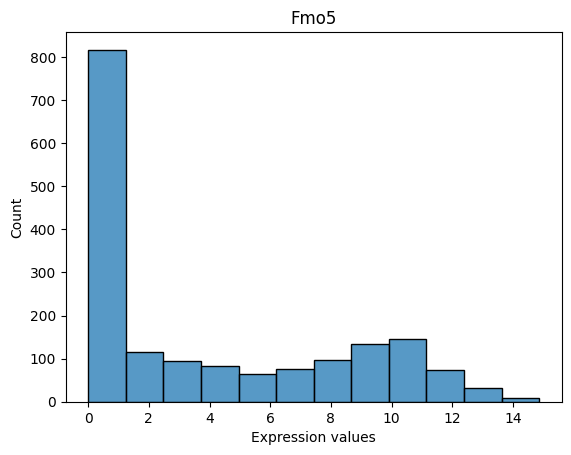

In [19]:
### write your code below ###

sns.histplot(facs, x = 'Fmo5')
plt.title('Fmo5')
plt.xlabel('Expression values')

We can also use boxplots to visualize gene expression distributions: copy the code you used above, but replace `sns.histplot()` with `sns.boxplot()`.

Text(0.5, 0, 'Expression values')

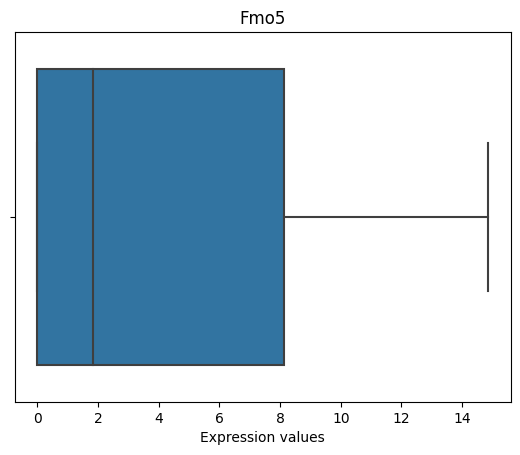

In [20]:
### write your code below ###

sns.boxplot(facs, x = 'Fmo5')
plt.title('Fmo5')
plt.xlabel('Expression values')

### Multiple distributions
There are several different ways to visualize multiple distributions at the same time. We'll use the plot types in the [Fundamentals of Data Visualization](https://clauswilke.com/dataviz/boxplots-violins.html), which are all available in `seaborn`.

As we mentioned before, `seaborn` is built for DataFrames and can make basic assumptions about how to plot your data. This is particularly useful for plotting multiple distributions.

Given a DataFrame of gene expression values, `seaborn` will automatically plot both columns and color them by their column labels.
* We've provided a list of genes called `subset_genes` below: select these columns from `facs` and assign the resultant DataFrame to a new variable called `subset_facs`.
* Provide `subset_facs` as the sole input to `sns.histplot()`.



<Axes: ylabel='Count'>

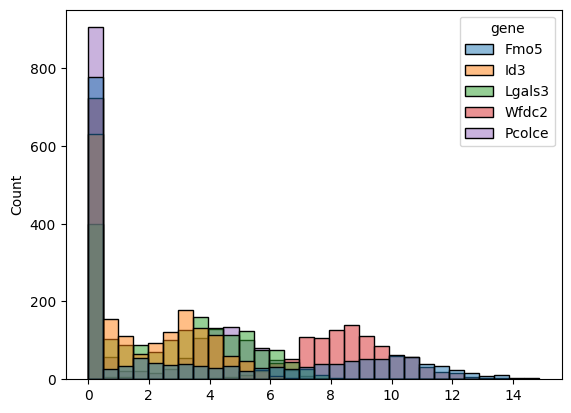

In [21]:
subset_genes = ['Fmo5', 'Id3', 'Lgals3', 'Wfdc2', 'Pcolce']

### write your code below ###
subset_facs = facs[subset_genes]
sns.histplot(subset_facs)

As you can see, histograms can become a bit visually busy with multiple distributions. Boxplots & boxplot variants (violin plots, boxen plots, strip plots, and swarm plots) tend to work much better for higher numbers of distributions visualized in the same plot.

Take a moment to see what these plots look like: simply substitute `sns.histplot()` with the functions below.
* `sns.boxplot()`
* `sns.violinplot()`
* `sns.boxenplot()`

The plots below work best for smaller datasets: we recommend using `subset_facs.sample(50)` to avoid warnings about overloading the plot.
* `sns.stripplot()`: This plot works best for mid-sized datasets: we recommend using `subset_facs.sample(500)` to avoid overloading the plot.
* `sns.swarmplot()`: This plot works best for smaller datasets: we recommend using `subset_facs.sample(25)` to avoid overloading the plot.

<Axes: xlabel='gene'>

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


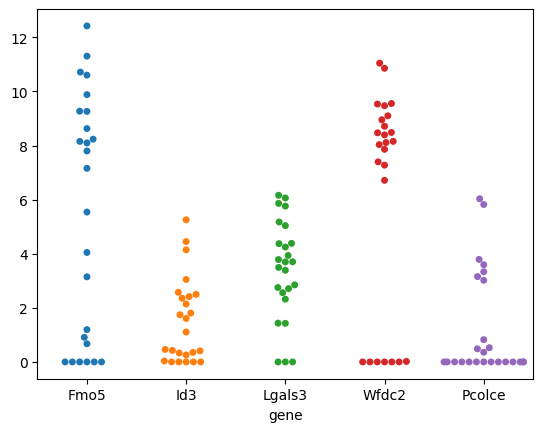

In [22]:
### write your code below ###
sns.swarmplot(subset_facs.sample(25))

### Subdivided distributions

Not all genes are expressed uniformly across all cells, especially cells of different types. What if we wanted to examine expression of these genes in different cell types? In order to do this, we'll need to *merge* our two DataFrames together into a super-DataFrame that contains all the information we want to use.

`facs` and `metadata_facs` can be merged using the row Index (row labels) of each DataFrame, which contains shared values (cell names). However, there's one small problem: the `facs` row Index doesn't actually have a name.

In [23]:
print('metadata_facs:', metadata_facs.index.name)
print('facs:', facs.index.name)

metadata_facs: index
facs: None


Recall that we can merge by providing a list of DataFrames/Series to `pd.merge()`, or by calling the `.merge()` method on an existing DataFrame. In either case, we need to specify the **merge key**: a column or index that has the same name in each DataFrame.

Below, perform the following operations:
* Update the `facs` Index name to match the `metadata_facs` index name.
* Merge `subset_facs` with `metadata_facs` using `'index'` as the merge key.
  * Save the resultant DataFrame to a new variable called `merged_subset`.

In [24]:
### write your code below ###
facs.index.rename('index', inplace = True)
merged_subset = subset_facs.merge(metadata_facs, on = 'index')
merged_subset.head()

,Fmo5,Id3,Lgals3,Wfdc2,Pcolce,FACS.selection,age,batch,cell,cell_ontology_class,...,free_annotation,mouse.id,plate,sex,well,Expressed Genes,UMI Count,Louvain Cluster,leiden,cluster_names
index,,,,,,,,,,,,,,,,,,,,,
E4_B000836_S40_L003.mus-0-0,0.000000,4.010118,2.076685,0.774455,4.519885,Multiple,24m,0,NaN,bladder cell,...,bladder mesenchymal cell (Scara5+),24_60_M,B000836,male,E4,3588,5226.1284,1,1,1_bladder cell
G13_B000836_S97_L003.mus-0-0,7.385960,0.000000,6.510249,10.069640,0.000000,Multiple,24m,0,NaN,bladder urothelial cell,...,luminal bladder epithelial cell (umbrella cell),24_60_M,B000836,male,G13,4249,5000.5464,0,2,0_bladder urothelial cell
H15_B000836_S123_L003.mus-0-0,4.439966,0.000000,6.102796,10.699270,0.024118,Multiple,24m,0,NaN,bladder urothelial cell,...,basal bladder epithelial cell (Krt5+),24_60_M,B000836,male,H15,3347,5055.2600,0,0,0_bladder urothelial cell
N10_B000836_S262_L003.mus-0-0,2.437131,1.022893,8.111483,10.787610,0.000000,Multiple,24m,0,NaN,bladder urothelial cell,...,luminal bladder epithelial cell (umbrella cell),24_60_M,B000836,male,N10,3314,5045.6357,0,2,0_bladder urothelial cell
O16_B000836_S292_L003.mus-0-0,0.861603,0.665913,7.327008,9.155251,0.000000,Multiple,24m,0,NaN,bladder urothelial cell,...,basal bladder epithelial cell (Krt5+),24_60_M,B000836,male,O16,4168,5039.3790,0,0,0_bladder urothelial cell


Using `merged_subset`, create a boxplot of gene expression for `Id3`, then subdivide the boxplot by `age` and `free_annotation`.

<Axes: xlabel='Id3', ylabel='age'>

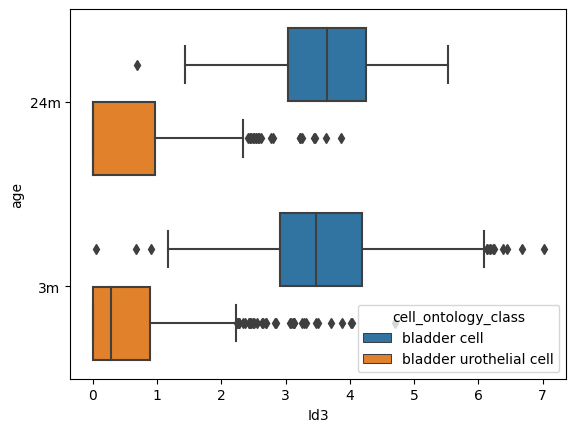

In [25]:
### write your code below ###

sns.boxplot(data = merged_subset, x = 'Id3', y = 'age', hue = 'cell_ontology_class')

## Principal component analysis

**Principal component analysis** is a technique commonly used in scRNA-seq data pre-processing, exploration, and visualization.

> *Principal component analysis (PCA) ... is accomplished by linearly transforming the data onto a new coordinate system (principal components) such that the directions capturing the largest variation in the data can be easily identified. Many studies use the first two principal components in order to plot the data in two dimensions and to visually identify clusters of closely related data points.*  - from [Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis)

### Feature selection

PCAs are typically used to summarize variation and reduce overall dimensionality in the dataset. scRNA-seq count matrices frequently have many thousands of dimensions (genes), with some genes contributing more to variation than others: these are, as you might predict, **highly variable genes** (HVGs). Filtering the count matrix to only contain highly variable genes is a process called **feature selection**

In [26]:
# identification of highly variable genes is beyond the scope of PyCamp
# so we've provided them for you here (an array of HVG gene names)
hvg = pd.read_csv('pythonbootcamp/day_5/hvg.csv')['genes'].values
hvg

array(['0610009B22Rik', '0610010B08Rik', '0610031O16Rik', ..., 'Zp2',
       'Zyg11b', 'Zzef1'], dtype=object)

From `facs`, select the columns in `hvg`: assign the resultant DataFrame to a new variable called `facs_hvg`.

In [27]:
### write your code below ###

facs_hvg = facs[hvg]
facs_hvg.head()

gene,0610009B22Rik,0610010B08Rik,0610031O16Rik,0610039K10Rik,1110001J03Rik,1110034G24Rik,1110038B12Rik,1110038D17Rik,1110054O05Rik,1110058L19Rik,...,Zfp90,Zfp940,Zfp942,Zfyve1,Zkscan14,Zmiz2,Zmym4,Zp2,Zyg11b,Zzef1
index,,,,,,,,,,,,,,,,,,,,,
E4_B000836_S40_L003.mus-0-0,0.000000,0.0,0.0,0.0,1.287125,0.0,1.831197,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,7.859654,0.0,0.0,0.0,0.046103
G13_B000836_S97_L003.mus-0-0,2.095577,0.0,0.0,0.0,0.464215,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,2.129131,0.000000,0.0,0.000000,0.0,0.0,0.0,0.353735
H15_B000836_S123_L003.mus-0-0,2.932742,0.0,0.0,0.0,0.000000,0.0,0.958776,0.0,0.0,0.916965,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
N10_B000836_S262_L003.mus-0-0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.105492,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.314571,0.0,0.000000,0.0,0.0,0.0,1.563915
O16_B000836_S292_L003.mus-0-0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.410234,0.0,0.0,0.409656,...,0.0,0.0,0.000000,0.000000,0.0,6.086046,0.0,0.0,0.0,0.000000


### Dimensionality reduction

We need to bring in another package to perform our PCA: `sklearn` is short for **scikit-learn**, a popular Python package used for machine learning applications.

We only need a single function from `sklearn`:
* `sklearn.decomposition.PCA()`: Creates a PCA generator object akin to the random number generator object created by `np.random.default_rng()`. Takes two inputs: the `n_components` parameter specifies the number of **principal components** (PCs) to be returned, and the `random_state` parameter allows you to set a seed value for the pseudo-random aspect of PCA.

Run the cell below to create the PCA generator object: we've set the random state to ensure that your results are comparable to the answer key.

In [28]:
# make sure to run this cell! nothing will work without it

import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components = 50, random_state = 7)

`pca` is a generator that will transform a dataset and summarize it into an array of the first 50 principal components. The first principal component (PC1) will summarize the largest amount of variation in the data, the second (PC2) will summarize the second largest amount of variation, and so on and so forth.

We need to use our new `pca` object to fit and transform `facs_hvg`: we can accomplish this by chaining together two methods:
* `.fit()`: Takes a DataFrame or array as input, fits `pca` to the input data.
* `.transform()`: Takes a DataFrame or array as input, transforms the input data according to `pca` into an array. **This method can only be used with the same input provided to `.fit()`**.

In [29]:
### write your code below ###

pca_array = pca.fit(facs_hvg).transform(facs_hvg)
pca_array

array([[ 5.44524007,  6.65766919,  5.63983862, ...,  3.79866334,
        -0.19587834, -5.51224648],
       [-5.43593779,  2.47030768, -3.2516017 , ..., -2.12880843,
         0.30749302,  1.77057158],
       [-2.88275096,  2.85000174,  0.38007722, ..., -1.60908187,
         2.82201752, -2.38461365],
       ...,
       [-5.17898619,  2.43523797, -0.14173339, ...,  0.71317709,
        -0.66477369, -0.72507156],
       [ 6.87047967, -0.17718595,  4.3224665 , ..., -1.74882275,
         0.96422645,  0.38909266],
       [-4.04383204,  0.94733112, -0.90255027, ...,  0.16517579,
         0.94637095,  0.13048717]])

This array contains the transformed principal component coordinates of each row in `facs`. However, this array is currently unlabeled, which will make it difficult for us to use in plotting: we need to transform it into a DataFrame with an appropriate index and column names.

Construct a DataFrame from `pca_array` using the `pd.DataFrame()` function, then assign it to a variable called `pca_df`. You will need to provide column labels and an index using the appropriate parameters, which you can find in the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

*Hint*: The PCA transformation reduces the number of columns, but the number and order of rows, as well as the row labels, remains unchanged.

In [30]:
### write your code below ###

pca_df = pd.DataFrame(pca_array,
                        columns = ['PC{n}'.format(n = x) for x in np.arange(1, 51)],
                        index=facs.index)
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
index,,,,,,,,,,,,,,,,,,,,,
E4_B000836_S40_L003.mus-0-0,5.445240,6.657669,5.639839,-4.556056,-2.245492,5.301169,-0.825150,1.324458,0.580297,-1.382483,...,-6.073211,-3.455978,-2.904808,0.810756,3.047877,1.517923,0.731453,3.798663,-0.195878,-5.512246
G13_B000836_S97_L003.mus-0-0,-5.435938,2.470308,-3.251602,0.682788,-5.488675,0.692977,-1.743829,0.845771,0.109232,-0.718699,...,0.392005,-2.400529,1.265227,-1.749463,-1.063524,0.188922,2.155126,-2.128808,0.307493,1.770572
H15_B000836_S123_L003.mus-0-0,-2.882751,2.850002,0.380077,-0.132634,-0.530040,1.282223,1.971778,0.869341,-3.135674,-3.696191,...,-1.586440,3.768356,-0.737223,1.490245,1.158444,1.207278,1.283037,-1.609082,2.822018,-2.384614
N10_B000836_S262_L003.mus-0-0,-4.794808,1.992067,-2.536444,1.285192,-3.638825,0.159846,-0.458165,-0.369279,-4.076263,0.680869,...,0.874491,-0.024850,-1.468081,0.200166,-1.331823,4.660072,-1.097713,-1.328208,-2.250795,-0.691267
O16_B000836_S292_L003.mus-0-0,-3.109015,3.352420,-1.153178,-0.232219,-2.966362,0.970759,1.086096,-0.511059,0.464507,-1.324284,...,1.885473,-1.408221,-0.263270,3.105354,2.991986,-0.762368,1.402718,1.424636,0.266889,-2.892552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P8.MAA000487.3_10_M.1.1-1,-4.427670,-1.008812,0.520079,0.121408,1.542892,-0.254312,2.128937,-0.686827,0.843262,-1.452990,...,0.737917,-0.309993,-0.993068,-0.110534,0.489194,0.076973,0.731691,0.537668,1.051213,-1.922613
P9.B000610.3_56_F.1.1-1,-2.743617,5.776178,-0.591478,1.344361,1.257565,-0.794524,-1.061075,-1.111957,-0.400055,3.306643,...,1.617423,-0.063690,1.701643,-1.284332,1.644612,0.740350,-0.305488,-0.767390,-0.088158,1.406974
P9.B002771.3_39_F.1.1-1,-5.178986,2.435238,-0.141733,0.303611,-0.270328,-1.218999,-0.441473,-0.571316,1.016427,0.121265,...,-1.040215,0.918819,-0.236434,1.166682,-0.441874,-1.971637,-0.505738,0.713177,-0.664774,-0.725072


## PCA visualization
As Wikipedia mentioned, it's quite common to use the first two principal components for exploratory visualization, as they capture the maximum amount of variation in the dataset in two dimensions.

Start off by creating a basic scatterplot of the first two PCs with `sns.scatterplot()`.
> *Note*: PCA plots typically hide coordinate values and ticks: you can remove x and y ticks on PCA plots by adding `plt.xticks([], [])` and `plt.yticks([], [])`. All plots in the answer key will obey this convention.

([], [])

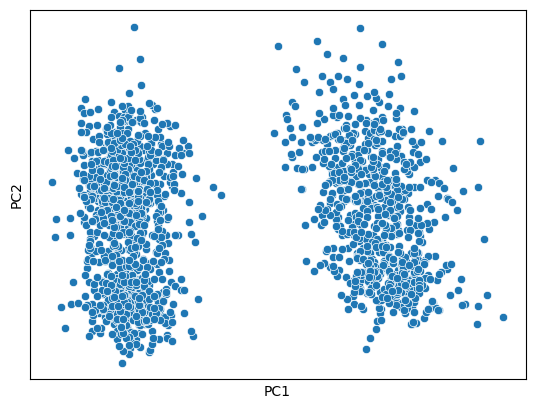

In [31]:
### write your code below ###
sns.scatterplot(pca_df, x = 'PC1', y = 'PC2')

# remove x and y ticks for visual clarity
plt.xticks([], [])
plt.yticks([], [])

### Metadata
PCA plots are typically colored by some metadata variable that may be relevant for understanding why data points cluster together: what if we simply added principal components as extra columns on our metadata table?

We can take advantage of the fact that `metadata_facs`, `facs`, and `facs_df` all use the same index: using the `.merge()` method, we can create a single convenient DataFrame containing the first two PCs and the metadata for each cell.

Select the first two PCs in `pca_df` and join them with `metadata_facs` using `.merge()`, assigning the resultant DataFrame to a variable called `pca_with_metadata`.

In [32]:
### write your code below ###

pca_with_metadata = pca_df[['PC1', 'PC2']].merge(metadata_facs, on = 'index')
pca_with_metadata

,PC1,PC2,FACS.selection,age,batch,cell,cell_ontology_class,cell_ontology_id,cellid,free_annotation,mouse.id,plate,sex,well,Expressed Genes,UMI Count,Louvain Cluster,leiden,cluster_names
index,,,,,,,,,,,,,,,,,,,
E4_B000836_S40_L003.mus-0-0,5.445240,6.657669,Multiple,24m,0,NaN,bladder cell,CL:1001319,E4_B000836,bladder mesenchymal cell (Scara5+),24_60_M,B000836,male,E4,3588,5226.1284,1,1,1_bladder cell
G13_B000836_S97_L003.mus-0-0,-5.435938,2.470308,Multiple,24m,0,NaN,bladder urothelial cell,CL:1001428,G13_B000836,luminal bladder epithelial cell (umbrella cell),24_60_M,B000836,male,G13,4249,5000.5464,0,2,0_bladder urothelial cell
H15_B000836_S123_L003.mus-0-0,-2.882751,2.850002,Multiple,24m,0,NaN,bladder urothelial cell,CL:1001428,H15_B000836,basal bladder epithelial cell (Krt5+),24_60_M,B000836,male,H15,3347,5055.2600,0,0,0_bladder urothelial cell
N10_B000836_S262_L003.mus-0-0,-4.794808,1.992067,Multiple,24m,0,NaN,bladder urothelial cell,CL:1001428,N10_B000836,luminal bladder epithelial cell (umbrella cell),24_60_M,B000836,male,N10,3314,5045.6357,0,2,0_bladder urothelial cell
O16_B000836_S292_L003.mus-0-0,-3.109015,3.352420,Multiple,24m,0,NaN,bladder urothelial cell,CL:1001428,O16_B000836,basal bladder epithelial cell (Krt5+),24_60_M,B000836,male,O16,4168,5039.3790,0,0,0_bladder urothelial cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P8.MAA000487.3_10_M.1.1-1,-4.427670,-1.008812,NaN,3m,1,P8.MAA000487.3_10_M.1.1,bladder urothelial cell,CL:1001428,NaN,luminal bladder epithelial cell (umbrella cell),3_10_M,NaN,male,NaN,6243,6392.4900,2,5,2_bladder urothelial cell
P9.B000610.3_56_F.1.1-1,-2.743617,5.776178,NaN,3m,1,P9.B000610.3_56_F.1.1,bladder urothelial cell,CL:1001428,NaN,luminal bladder epithelial cell (umbrella cell),3_56_F,NaN,female,NaN,4733,6257.6816,5,3,5_bladder urothelial cell
P9.B002771.3_39_F.1.1-1,-5.178986,2.435238,NaN,3m,1,P9.B002771.3_39_F.1.1,bladder urothelial cell,CL:1001428,NaN,luminal bladder epithelial cell (umbrella cell),3_39_F,NaN,female,NaN,5446,6136.8400,5,3,5_bladder urothelial cell


Once you're ready, create the PCA scatterplot just as you did before: this time, use the `hue` parameter to color the PCA plot by `cell_ontology_class`.

([], [])

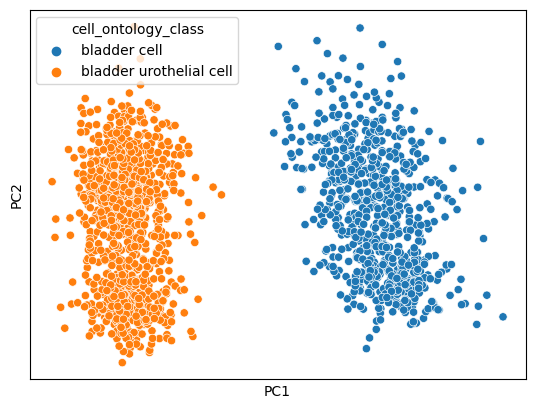

In [33]:
### write your code below ###

sns.scatterplot(pca_with_metadata, x = 'PC1', y = 'PC2', hue = 'cell_ontology_class')

# remove x and y ticks for visual clarity
plt.xticks([], [])
plt.yticks([], [])

### Gene expression

Let's take this one step further by coloring our plot with gene expression values from `facs`.

The authors of the Tabula Muris Senis [paper](https://www.nature.com/articles/s41586-020-2496-1) identified the top 20 genes upregulated and downregulated with age in three different tissues, including the bladder (Fig. 2F). Below, we've transcribed the list of genes from the figure for your convenience.

In [34]:
age_up = ['Sprr1a', 'Ly6d', 'Lgals3', 'Wfdc2', 'Gsta4', 'Gsto1', 'Krt18', 'Sfn',
          'Krt8', 'Areg', 'Aqp3', 'Igfbp2', 'Krt15', 'Gstm1', 'Krt19', 'Fxyd3',
          'Akr1b8', 'Foxq1', 'Cldn4', 'Krt7']

age_down = ['Pcolce', 'Ppic', 'Id3', 'Col6a2', 'Gadd45g', 'Tuba1a', 'Fos', 'Dcn',
            'Col5a2', 'Htra1', 'Car3', 'Rcn3', 'Mgp', 'Lgals1', 'Col6a1',
            'Col1a1', 'Serpinh1', 'Sparc', 'Col1a2', 'Col3a1']

Although our dataset is very high-quality, it's still useful to perform little sanity checks to make sure that everything is as it should be: in this case, we should make sure that all of the genes listed in the figure are actually in `facs`.

Let's take this opportunity to review two core concepts: writing custom functions and using `for` loops.

In [35]:
# write a custom function called gene_check() that fulfills the following requirements:
# 1) takes two inputs: a list of genes (gene_list), and a DataFrame (df)
# 2) uses a for loop to check if each gene in age_up exists in df
# 3) if the gene is not in df, prints a warning message of your choice that
# includes the gene name

### write your code below ###

def gene_check(gene_list, df):
  for gene in gene_list:
    if gene not in df:
      print("{gene} is not in the table!".format(gene = gene))

In [36]:
# use this cell to test your function
# none of the genes in control_genes should be found in facs
# all of the genes in age_up and age_down should be found in facs

control_genes = pd.Series(['BRCA1', 'APOE', 'LCT'])
control_genes.index = control_genes

gene_check(control_genes, facs)

BRCA1 is not in the table!
APOE is not in the table!
LCT is not in the table!


Now that we've verified that all of our aging-upregulated and downregulated genes are present in `facs`, we can color our PCA plot by individual genes and their expression values.

Just as you did before, select the first two PCs from `pca_df` and join them with `facs` using `.merge()`, assigning the resultant DataFrame to `pca_with_expression`.

In [37]:
### write your code below ###

pca_with_expression = pca_df[['PC1', 'PC2']].merge(facs, on = 'index')
pca_with_expression

,PC1,PC2,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,...,Zxda,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
index,,,,,,,,,,,,,,,,,,,,,
E4_B000836_S40_L003.mus-0-0,5.445240,6.657669,0.0,3.492475,0.000000,0.000000,3.145103,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,3.715508,0.046103,0.000000,0.0,1.361832
G13_B000836_S97_L003.mus-0-0,-5.435938,2.470308,0.0,0.110136,0.683075,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,1.924983,0.353735,0.295342,0.0,0.000000
H15_B000836_S123_L003.mus-0-0,-2.882751,2.850002,0.0,2.208737,0.000000,0.000000,0.000000,0.000000,1.582912,0.0,...,0.000000,0.0,5.248287,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.227322
N10_B000836_S262_L003.mus-0-0,-4.794808,1.992067,0.0,2.201469,4.455325,0.000000,0.000000,4.005048,0.000000,0.0,...,0.000000,0.0,5.874591,0.0,0.000000,0.000000,1.563915,0.000000,0.0,1.497999
O16_B000836_S292_L003.mus-0-0,-3.109015,3.352420,0.0,0.810299,2.653487,0.000000,0.000000,0.000000,6.331416,0.0,...,0.116078,0.0,0.000000,0.0,0.000000,1.092152,0.000000,0.147338,0.0,2.551033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P8.MAA000487.3_10_M.1.1-1,-4.427670,-1.008812,0.0,0.651597,2.522153,0.000000,0.000000,1.000555,1.236034,0.0,...,0.000000,0.0,0.000000,0.0,2.827979,2.694953,0.046731,0.347321,0.0,1.502668
P9.B000610.3_56_F.1.1-1,-2.743617,5.776178,0.0,1.618331,0.000000,0.000000,0.000000,2.160478,3.410619,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,1.875177,0.000000,0.000000,0.0,0.000000
P9.B002771.3_39_F.1.1-1,-5.178986,2.435238,0.0,2.086518,0.032433,0.000000,0.000000,0.845165,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.974794,0.000000,0.000000,0.0,1.238839


Once you're done, you can color your PCA plot with expression values from `age_up` and `age_down`, just like you did with the metadata.

This excerpt from the article suggests some specific genes of interest:

> "*... using differential gene expression analysis to assess overall changes in tissues with age, we found that stromal-associated genes (Col1a1, Col1a2, Col3a1 and Dcn) are downregulated while epithelial-associated genes (Krt15, Krt18 and Sfn) are upregulated, supporting the compositional observations.*"

Notes:
* Set the `palette` parameter with a continuous palette of your choice: you can view different options [here](https://www.practicalpythonfordatascience.com/ap_seaborn_palette).
* For most palettes, it's advisable to also use the optional `legend = None` and `linewidth = 0` parameters to reduce visual noise.
* Expression values will be plotted with a wide color spectrum: we recommend sorting the DataFrame by the gene's expression values.
  * This ensures that the "brightest" points are plotted last, making it easier to see patterns in the colored plot.

If you want to change additional aspects of your plot, you can view the documentation for `sns.scatterplot()` [here](https://seaborn.pydata.org/generated/seaborn.scatterplot.html).


([], [])

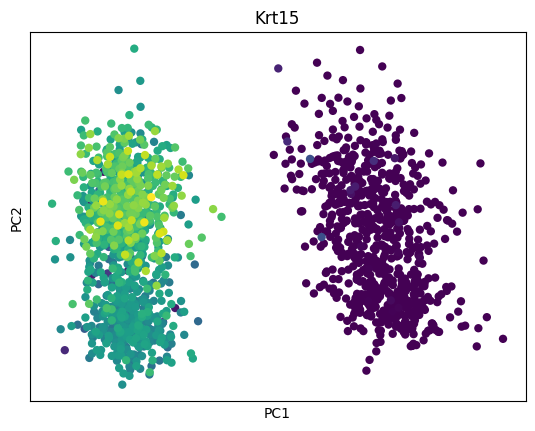

In [38]:
### write your code below ###

sns.scatterplot(data = pca_with_expression.sort_values('Krt15'), x = 'PC1', y = 'PC2',
                hue = 'Krt15', palette = 'viridis', linewidth = 0, legend = None)
plt.title('Krt15')

# remove x and y ticks for visual clarity
plt.xticks([], [])
plt.yticks([], [])

## Final steps


### Saving plots

`pyplot` offers a convenient function for saving plots. `plt.savefig()` requires a filename (`fname`) and takes an optional `dpi` parameter. We recommend using `dpi = 300` for publication-ready plots.

To save your plot, simply add `plt.savefig()` to the end of your plotting cell, then run the cell.

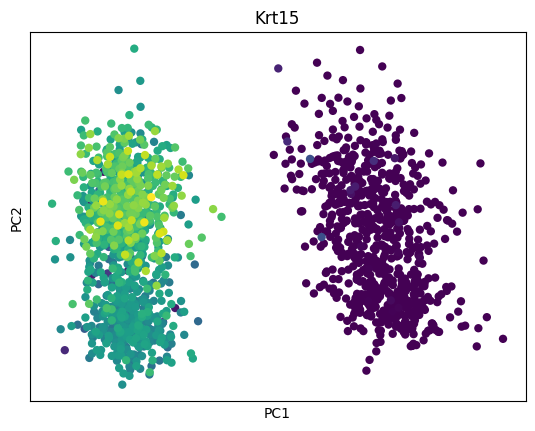

In [39]:
### place the code for your favorite plot below ###

sns.scatterplot(data = pca_with_expression.sort_values('Krt15'), x = 'PC1', y = 'PC2',
                hue = 'Krt15', palette = 'viridis', linewidth = 0, legend = None)
plt.title('Krt15')
plt.xticks([], [])
plt.yticks([], [])

### place the code for your favorite plot above ###

plt.savefig('my_favorite_plot.png', dpi = 300)

You can now download this plot from the Files menu. (If it hasn't appeared, try refreshing the Files menu.)

### The ultimate test: comparing to `scanpy`

There are many, many packages available for single-cell data analysis in Python: we just installed `scanpy`, a very popular package that was used in the full Tabula Muris Senis dataset analysis.

Packages like `scanpy` are well-loved because they bundle together many single-cell operations and analyses into individual functions. Below, we've written the `scanpy` commands that replicate each step of what we did above, down to the final PCA plot.

In [40]:
# we need to use pip to install scanpy first
# this should take < 30 seconds
!pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=6da808fd8018585cf5dca2cc26f4ab2075d958c7039067214046980949236845
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8027 sha256=5ea58a155d6f0f4633e896dab6ab10eee870e20ab31300b9d6c75bc9264f61e0
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd

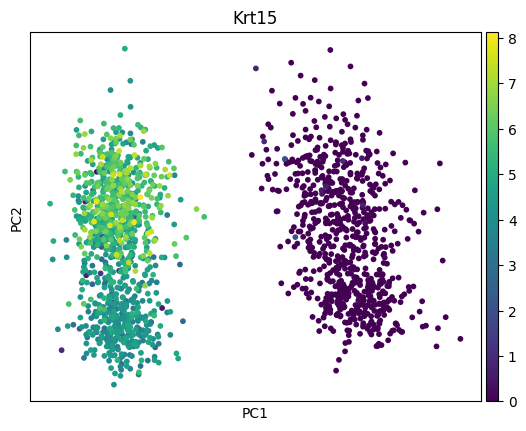

In [41]:
import scanpy as sc
import anndata

# creates an object called adata that "holds" both the count matrix and metadata
# it's basically a container for various DataFrames in the dataset
adata = anndata.AnnData(X = facs)
adata.obs = metadata_facs

# calculates highly variable genes and updates adata
sc.pp.highly_variable_genes(adata)

# performs PCA and updates adata
sc.tl.pca(adata)

# creates a PCA plot and colors it by one of our genes of interest
# it automatically sorts gene expression and places brightest points last
sc.pl.pca(adata, color='Krt15')

Hopefully this looks similar to your PCA plot when colored by the same gene. If so, **congratulations**: you've matched the power of one of the most popular Python single-cell analysis packages!

> *Note*: Colorbars aren't available in `seaborn`, only `pyplot` 😢 We wanted to emphasize `seaborn` today, but you can overcome this aesthetic difference simply using `plt.scatter()` and `plt.colorbar()` in place of `sns.scatterplot()`. Don't let that detract from your victory over Python!

# Moving on with Python
This marks the end of PyCamp (😢), but hopefully not the end of your Python journey (🐍).

The best way for you to get better with Python is to find a way to utilize it in your existing data analysis workflow. Although it might be a little bit of a slow start as you figure out how to build your analyses, practice makes perfect!

If you'd like tutorials that go beyond the `numpy`/`pandas`/`pyplot`/`seaborn` content covered in PyCamp, consider working through the materials available on [DataQuest](dataquest.io) or [Calm Code](https://calmcode.io/). Both websites provide walkthroughs and exercises for specific data tasks, and you may find them helpful for reinforcing and filling in any gaps that exist post-PyCamp.

Alternatively, if you're more of a book person, we recommend the following interactive books that are *also* published as physical books. You can order these via your favorite local/online bookshop.
* **Python for Data Analysis: Data Wrangling with Pandas, NumPy, and Python**: [online version](https://github.com/wesm/pydata-book); [publisher website](https://www.oreilly.com/library/view/python-for-data/9781491957653/)
* **Python Data Science Handbook**: [online version](https://github.com/jakevdp/PythonDataScienceHandbook), [publisher website](https://www.oreilly.com/library/view/python-data-science/9781491912126/)
* **Mastering Python for Bioinformatics: How to Write Flexible, Documented, Tested Python Code for Research Computing**: [online version](https://github.com/kyclark/biofx_python), [publisher website](https://www.oreilly.com/library/view/mastering-python-for/9781098100872/)

All of the packages below have extensive tutorials and documentation, so you'll be able to transition fairly seamlessly from the PyCamp style tutorial of "watch and repeat" to working on your own code!

* [SciPy](https://scipy.org/): A package that expands upon `numpy`, providing fundamental algorithms & functions for mathematical and statistical operations.
  * [scikit-image](https://scikit-image.org/): An affiliated package that provides image processing algorithms & functions.
  * [scikit-learn](https://scikit-learn.org/stable/): An affiliated package that provides machine learning algorithms and functions, one of which we used today for PCA!
* [Biopython](https://biopython.org/): A package for parsing and working with protein & sequence data, ranging from sequence parsing to alignment and querying of public databases.
* [statsmodels](https://www.statsmodels.org/stable/index.html): A module for statistical modeling and tests, expanding upon data structures from `numpy` and `pandas`.
* [keras](https://keras.io/): A relatively user-friendly package for deep learning.

# Challenge zone

The prompts below will require some more advance `pyplot`, `seaborn` and `pandas` techniques that we haven't covered explicitly in PyCamp. If you've finished early and would like to push yourself a bit, try them out: **note that we will not cover these solutions in session**.

## Multi-plot plots

Let's say that we want to examine many different genes and their expressions within the figure. We can create multi-plot figures using `pyplot` and `seaborn` together.

Multi-plot figures in `pyplot` are created with two types of objects.
* **Figure**: A Figure object is the "base" of your figure, akin to a blank canvas.
* **Subplot**: A Subplot is an object that only exists relative to a Figure: it specifies where your plotted data should go on the Figure.

Below is an example image that shows what a Figure object with one subplot looks like.

![fig_map](https://github.com/ccbskillssem/pythonbootcamp/raw/main/day_5/fig_map.png)

The simplest way to get started is to use the `plt.subplots()` function, which creates a grid of `(nrows, ncols)` subplots. This function takes several parameters:
* `nrows`: The number of rows in your grid of subplots.
* `ncols`: The number of columns in your grid of subplots.
* `figsize`: As described for `plt.figure()` earlier, a tuple of `(width, height)`.
* `layout`: Configures orientation of subplots. We recommend setting `layout = 'tight'` to minimize whitespace between subplots.

`plt.subplots()` will return a Figure and an array of Subplot objects, which are typically assigned to variables called `fig` and `axes`.

Figure: Figure(400x400)
Subplots: [[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]


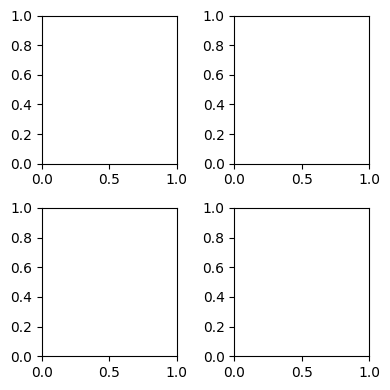

In [42]:
# example: a Figure with four Subplots
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (4, 4), layout = 'tight')

print('Figure:', fig)
print('Subplots:', axes)

The code below creates a Figure with a 2 x 2 grid of Subplots. It takes advantage of two new functions/methods:
* `.flatten()`: A method for arrays, which converts `axes` from a 2 x 2 array to a 1 x 4 array that we can use in a `for` loop.
* `zip()`: A built-in function that "zips" together iterables (list, array, etc) of equivalent length. The first gene is matched with the first subplot, and so on and so forth.

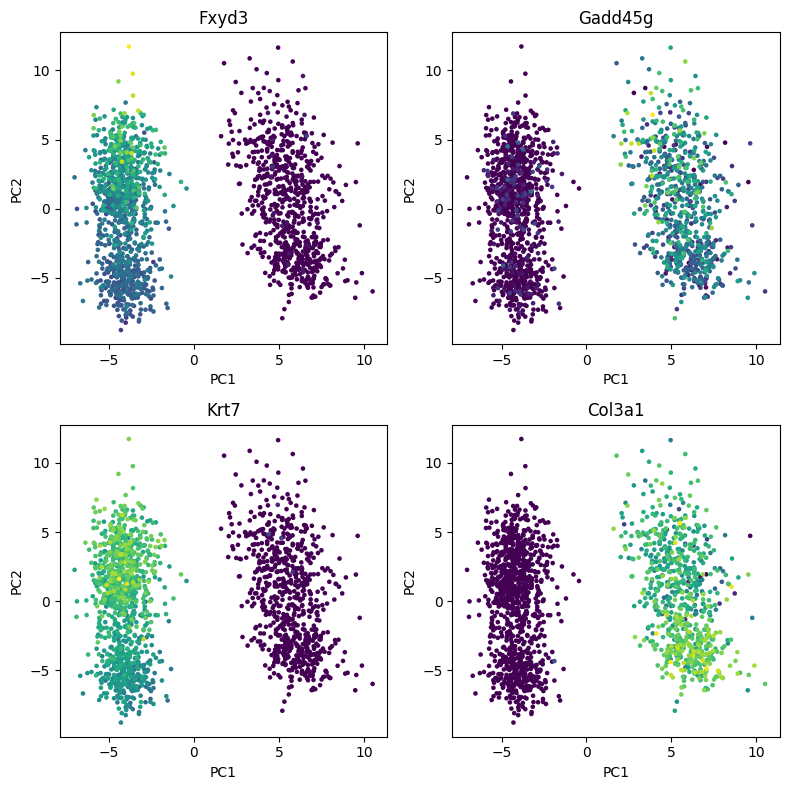

In [43]:
# example: what if we wanted to create a Figure of 2x2 subplots
# each containing a PCA plot colored by a different gene?
# this will take a moment to generate

plot_genes = ['Fxyd3', 'Gadd45g', 'Krt7', 'Col3a1']

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 8), layout = 'tight')
axes = axes.flatten()

for gene, ax in zip(plot_genes, axes.flatten()):
  sns.scatterplot(pca_with_expression.sort_values(gene), x = 'PC1', y = 'PC2',
                  hue = gene, ax = ax,
                  palette = 'viridis', linewidth = 0, s = 11, legend = None)
  ax.set_title(gene)

Using the above code as a skeleton, create a Figure with a subplot for each gene in `age_up` (or `age_down`). You will need to adjust the grid dimensions and Figure size.

We recommend making these changes as well:
* Use `.sort_values()`, as described earlier, to sort the DataFrame by the gene's expression values.
* Add a title to each subplot: at minimum, it should contain the gene name.
* Disable the legend in `sns.scatterplot()`: you can see how busy the plot is already!

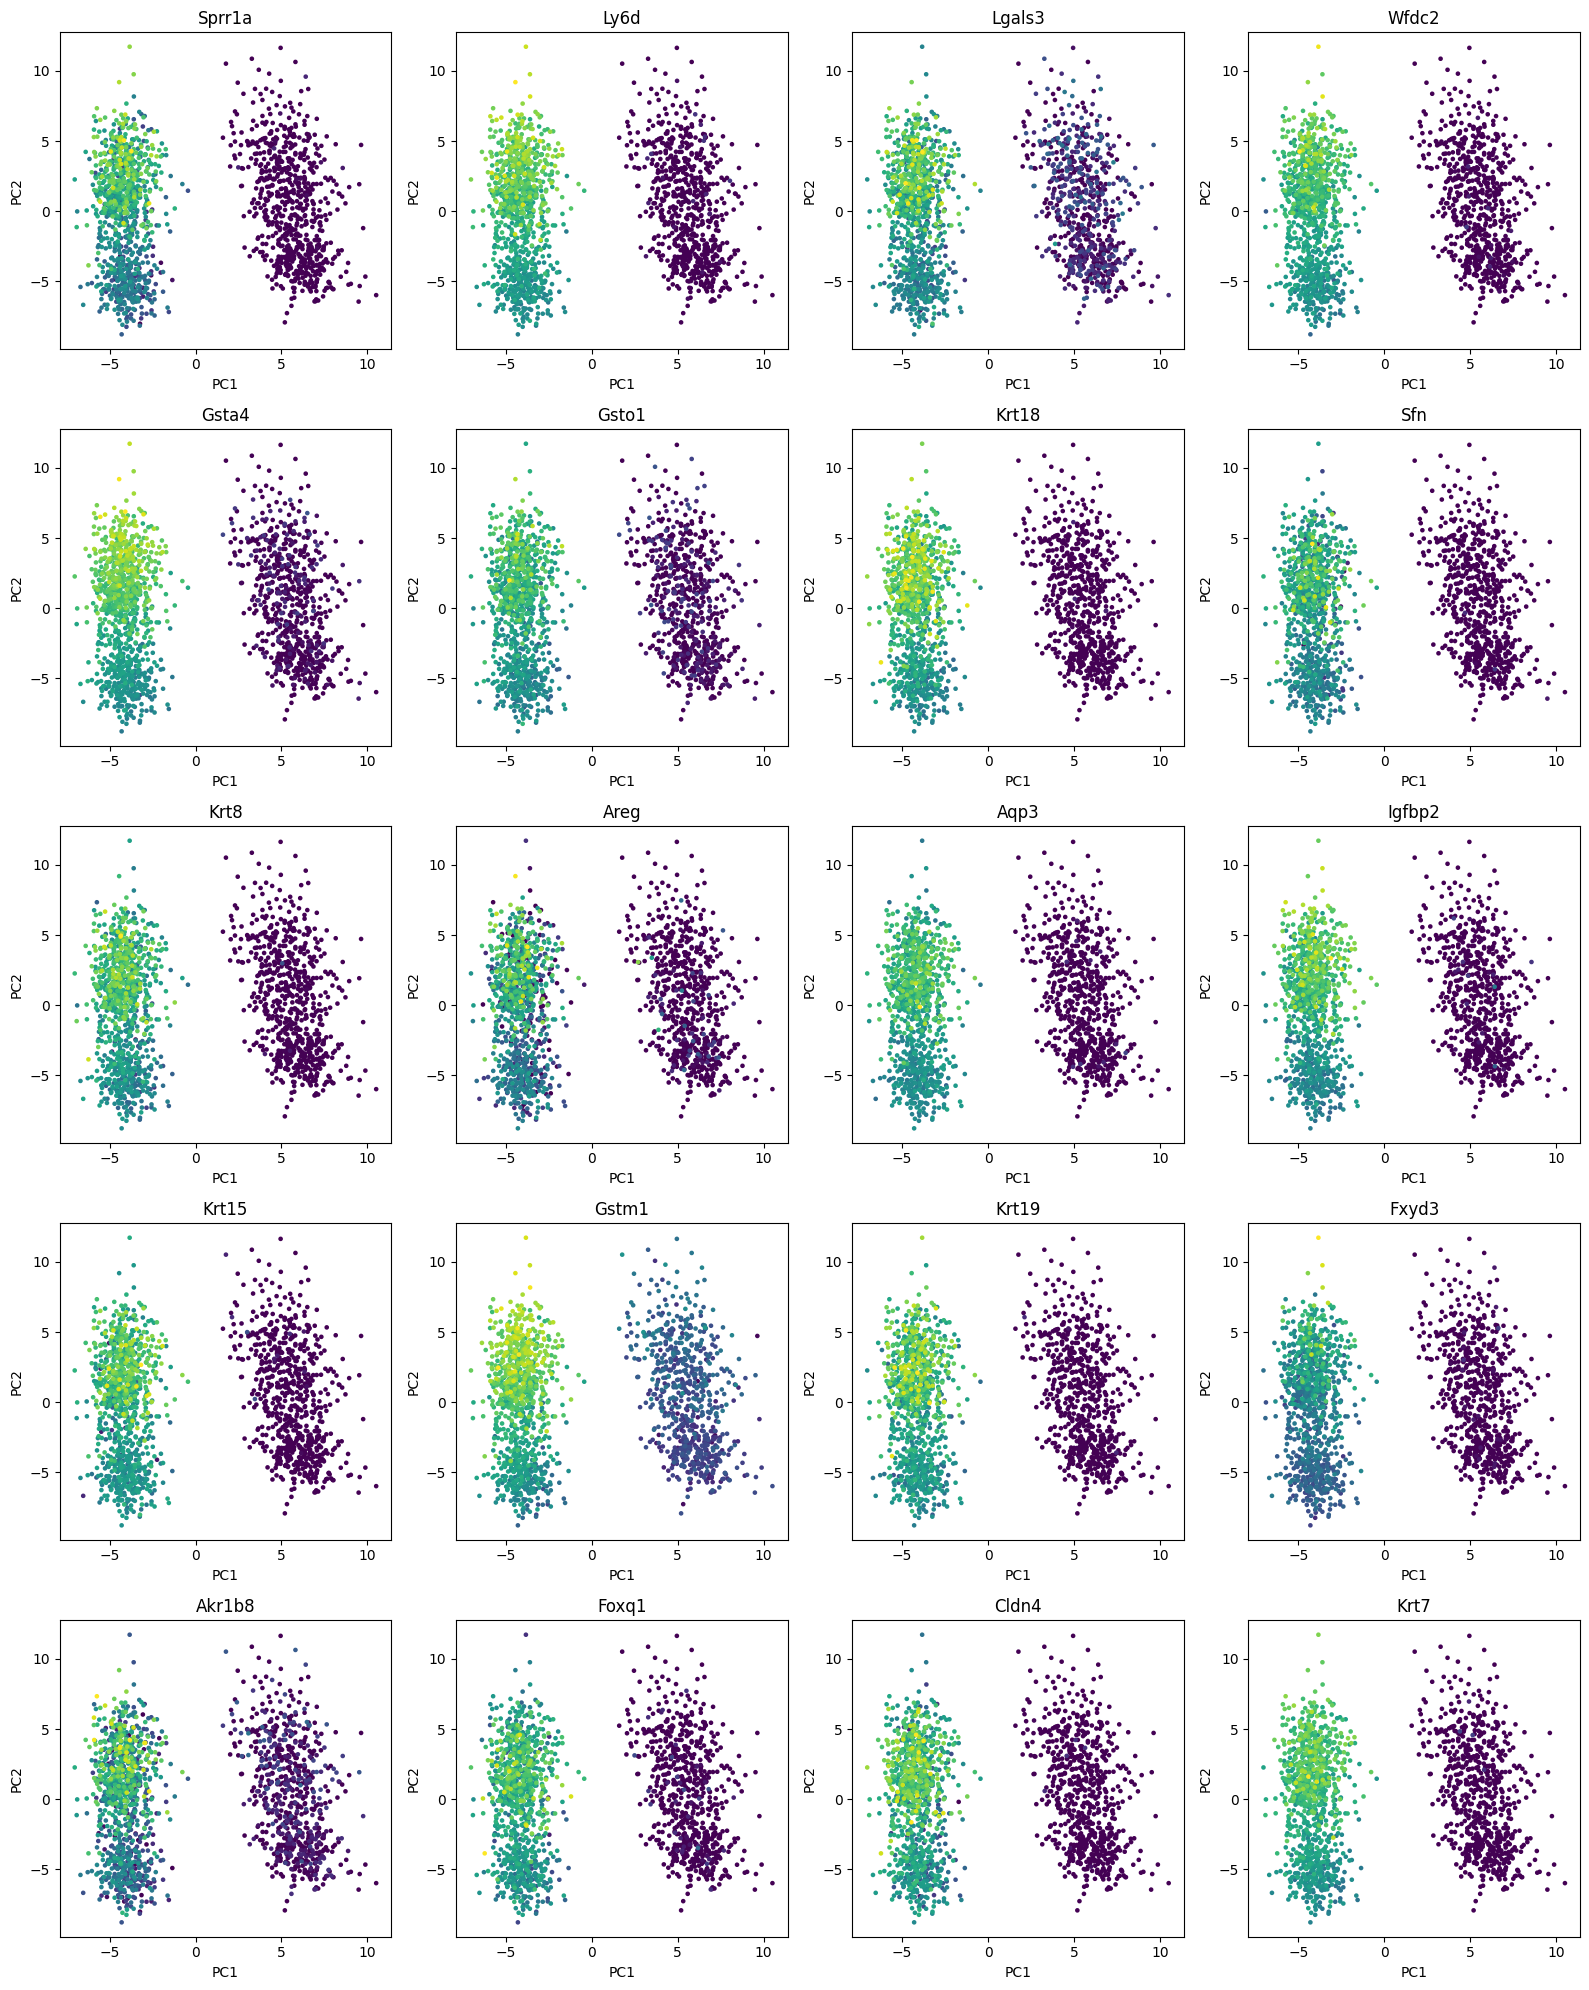

In [44]:
### write your code below ###
### plots will take a while to generate! ###
fig, axes = plt.subplots(ncols = 4, nrows = 5, figsize = (16, 20), layout = 'tight')
axes = axes.flatten()

for gene, ax in zip(age_up, axes):
  sns.scatterplot(data = pca_with_expression.sort_values(gene),
                  x = 'PC1', y = 'PC2', hue = gene,
                  palette = 'viridis', linewidth = 0, s = 11, legend = None, ax = ax)
  ax.set_title(gene)

## Changes in relative cell proportions with age (Fig. 2E)

The Tabula Muris Senis dataset contains data derived from two different single-cell techniques:

| Technique   | Quantity of cells | Sensitivity |
| ----------- | ----------------- | ----------- |
| Microfluidic droplet-based sequencing      | +++       | +       |
| FACS-sorted plate-based sequencing   | +        | +++       |

Each technique has its own pros and cons: in this mini-project, we worked on the FACS data because its count matrix is smaller and less likely to overlab Colab's memory (and destroy your work in progress!)

Let's try to replicate the figure and analysis of Figure 2E ("Bladder cell"; "Bladder urothelial cell"), which uses the larger droplet sequencing dataset. The figure and relevant section from the paper are reprinted below for your convenience.

> *The cellular composition of each tissue type tends to vary with age. We investigated changes in the cellular composition of tissues for which data from at least three time points was available ...<br><br>The bladder shows pronounced changes in cell-type composition with age (Fig. 2e): whereas the mesenchymal compartment of this tissue decreases by a factor of three over the lifetime of the mouse (Fig. 2e, left), the urothelial compartment increases by a similar amount (Fig. 2e, right). The observation that the proportion of bladder urothelial cells increases with age is concordant with known age-related urothelial changes [25].*


<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41586-020-2496-1/MediaObjects/41586_2020_2496_Fig2_HTML.png?as=webp">

In [45]:
# run this cell to download the droplet metadata: this should only take a few seconds
%%bash
wget https://cells.ucsc.edu/tabula-muris-senis/droplet/bladder/meta.tsv -O bladder-droplet.meta.tsv --no-check-certificate --no-verbose

  Unable to locally verify the issuer's authority.
2024-01-04 22:08:44 URL:https://cells.ucsc.edu/tabula-muris-senis/droplet/bladder/meta.tsv [1734324/1734324] -> "bladder-droplet.meta.tsv" [1]


In [46]:
# use the appropriate pandas function to load in bladder-droplet.meta.tsv
# and assign it to a variable called metadata_droplet

metadata_droplet = pd.read_table('bladder-droplet.meta.tsv')
metadata_droplet.head()

,index,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,mouse.id,Expressed Genes,sex,subtissue,UMI Count,Louvain Cluster,cluster_names,auto_cell_ontology_id
0,AAACCTGAGTACGTTC-1-24-0-0,18m,0,MACA_18m_M_BLADDER_52_unstain_AAACCTGAGTACGTTC,bladder urothelial cell,CL:1001428,luminal bladder epithelial cell (umbrella cell),18-M-52,2777,male,Unstain,17658.0,5,5_bladder urothelial cell,NaN
1,AAACCTGGTCGAACAG-1-24-0-0,18m,0,MACA_18m_M_BLADDER_52_unstain_AAACCTGGTCGAACAG,bladder cell,CL:1001319,bladder mesenchymal cell (Car3+),18-M-52,1821,male,Unstain,6714.0,7,7_bladder cell,NaN
2,AAACCTGGTCTCCCTA-1-24-0-0,18m,0,MACA_18m_M_BLADDER_52_unstain_AAACCTGGTCTCCCTA,bladder urothelial cell,CL:1001428,luminal bladder epithelial cell (umbrella cell),18-M-52,2704,male,Unstain,12811.0,4,4_bladder urothelial cell,NaN
3,AAACCTGTCTTCGAGA-1-24-0-0,18m,0,MACA_18m_M_BLADDER_52_unstain_AAACCTGTCTTCGAGA,bladder cell,CL:1001319,bladder mesenchymal cell (Scara5+),18-M-52,1407,male,Unstain,4161.0,3,3_bladder cell,NaN
4,AAACGGGGTTGCTCCT-1-24-0-0,18m,0,MACA_18m_M_BLADDER_52_unstain_AAACGGGGTTGCTCCT,endothelial cell,CL:0000115,endothelial cell,18-M-52,1835,male,Unstain,5310.0,11,11_endothelial cell,NaN


Figure 2E shows that the relative proportion of bladder cells decreases with age, whereas the relative proportion of bladder urothelial cells increases with age. Both trends are statistically significant.

In order to create a plot-friendly DataFrame, you will need to do the following:
* Get group-based counts of cells by `age` and `cell_ontology_class` as a DataFrame. (Make sure it's a DataFrame and not a Series!)
* Create a new column with relative proportions of cell counts for each age group. **Make sure to check that the relative proportions for each sample sum up to 1.**
  * *Hint*: The `.transform()` method is very powerful for "filling in" values to each row that were originally calculated with grouped rows. Relevant StackOverflow answers for calculating relative proportions are likely to suggest that you use `.transform()`.
* Replace the strings in ages with `int` or `float` equivalents (ex. `3` instead of `3m`). This will make your data easier to plot.
* When you're confident that everything looks the way it should, reset the DataFrame index. This returns the data to a non-hierarchical format that `seaborn` and `pyplot` can parse.

In [47]:
### write your code below ###

droplet_proportions = metadata_droplet.value_counts(['mouse.id', 'age', 'cell_ontology_class'], sort = False).to_frame(name = 'count')
droplet_proportions['rel_prop'] = droplet_proportions['count']/droplet_proportions.groupby(['mouse.id', 'age'])['count'].transform('sum').values
droplet_proportions['check_sum'] = droplet_proportions.groupby(['mouse.id', 'age'])['rel_prop'].transform('sum').values # calculate that relative proportions sum to 1
droplet_proportions.reset_index(inplace = True)
droplet_proportions.replace({'1m': 1, '3m': 3, '18m': 18, '24m': 24}, inplace = True)

droplet_proportions

,mouse.id,age,cell_ontology_class,count,rel_prop,check_sum
0,1-M-63,1,bladder cell,620,0.648536,1.0
1,1-M-63,1,bladder urothelial cell,186,0.194561,1.0
2,1-M-63,1,endothelial cell,117,0.122385,1.0
3,1-M-63,1,leukocyte,33,0.034519,1.0
4,18-M-52,18,bladder cell,517,0.256576,1.0
5,18-M-52,18,bladder urothelial cell,1382,0.685856,1.0
6,18-M-52,18,endothelial cell,36,0.017866,1.0
7,18-M-52,18,leukocyte,80,0.039702,1.0
8,24-M-58,24,bladder cell,287,0.207820,1.0
9,24-M-58,24,bladder urothelial cell,932,0.674873,1.0


Finally, let's create the plot(s).

You'll need to use `sns.regplot()`, which will draw both a scatterplot and linear regression line. You can view the documentation for `sns.regplot()` [here](https://seaborn.pydata.org/generated/seaborn.regplot.html).

Notes:
* You can draw separate plots for `'Bladder cell'` and `'Bladder urothelial cell'` or use `plt.subplots()` to create a single Figure with two plots.
* You can alter the regression line style to a black dashed line using `line_kws = {'linestyle': 'dashed', 'color': 'black'}`.
* For this exercise, ignore the different scatter point colors.

Text(0.5, 1.0, 'Bladder cell')

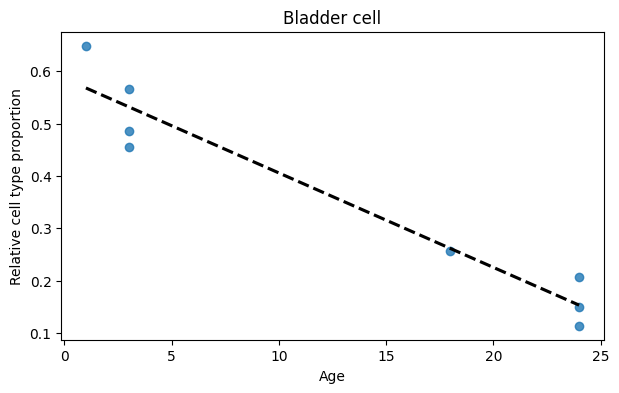

In [48]:
### write your code for the Bladder cell plot below ###

plt.figure(figsize = (7, 4))

bladder_cells = droplet_proportions.query("cell_ontology_class == 'bladder cell'")

sns.regplot(bladder_cells,
            x = 'age', y = 'rel_prop',
            ci = False,
            line_kws = {'linestyle': 'dashed', 'color': 'black'})

plt.xlabel('Age')
plt.ylabel('Relative cell type proportion')
plt.title('Bladder cell')

Text(0.5, 1.0, 'Bladder urothelial cell')

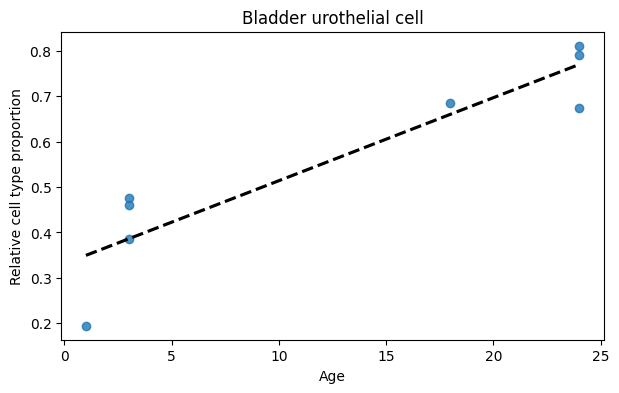

In [49]:
### write your code for the Bladder urothelial cell plot below ###
plt.figure(figsize = (7, 4))

bladder_urothelial_cells = droplet_proportions.query("cell_ontology_class == 'bladder urothelial cell'")

sns.regplot(bladder_urothelial_cells,
            x = 'age', y = 'rel_prop',
            ci = False,
            line_kws = {'linestyle': 'dashed', 'color': 'black'})

plt.xlabel('Age')
plt.ylabel('Relative cell type proportion')
plt.title('Bladder urothelial cell')

As a final touch, we can repeat the statistical analysis described below.

> *The relative abundances of bladder cells ... and bladder urothelial cells ... change significantly with age. P < 0.05 and r2 > 0.7 for a hypothesis test with the null hypothesis that the slope is zero, using two-sided Wald test with t-distribution of the test statistic.*

We can perform this test using `scipy.stats.linregress()`. The documentation for this function is [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html). You will need to perform this test once for `Bladder cells`, then again for `Bladder urothelial cells`.

In [50]:
from scipy import stats

### write your code below ###
print('Bladder cells:', stats.linregress(bladder_cells['age'], bladder_cells['rel_prop'], alternative = 'two-sided'))
print('Bladder urothelial cells:', stats.linregress(bladder_urothelial_cells['age'], bladder_urothelial_cells['rel_prop'], alternative = 'two-sided'))

Bladder cells: LinregressResult(slope=-0.01802274184258342, intercept=0.5859271737708966, rvalue=-0.9647218555570722, pvalue=0.00010687962031633186, stderr=0.0020079205495393384, intercept_stderr=0.03237674601698282)
Bladder urothelial cells: LinregressResult(slope=0.01828125877881235, intercept=0.3312806204223834, rvalue=0.9212201220960402, pvalue=0.0011512398951039691, stderr=0.003151833523787183, intercept_stderr=0.05082178849700067)
